#### Lab Design 2 - Sentiment Analysis Using Pre Trained Models.

In [42]:
# Importing required libraries.

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [36]:
# Loading the dataset.

init_data = pd.read_csv('train.csv')

#### Quick EDA!

In [37]:
init_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [38]:
# Selecting the required columns.

df = init_data[['text', 'selected_text', 'sentiment']]

df.head()

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
# Dropping the data having the sentiment - 'Neutral'.
# Since our Hugging Face Transformers only labels the predictions as 'Postive' or 'Negative'.

data = df[df['sentiment'] != 'neutral']

data.head()

,text,selected_text,sentiment
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
6,2am feedings for the baby are fun when he is a...,fun,positive


In [40]:
# Checking for null values.

data.isnull().sum()

text             0
selected_text    0
sentiment        0
dtype: int64

In [11]:
# Cleaning the data. (Basic cleaning)

def cleaningText(text):
    
    # Converting to lowercase.
    text = text.lower()

    # Removing special characters, numbers etc.
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Stripping the extra whitespaces.
    text = text.strip()

    return text

In [41]:
# Applying the cleaning function on the data.

data['cleaned_text'] = data['selected_text'].apply(cleaningText)
data.head()

,text,selected_text,sentiment,cleaned_text
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad
2,my boss is bullying me...,bullying me,negative,bullying me
3,what interview! leave me alone,leave me alone,negative,leave me alone
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of
6,2am feedings for the baby are fun when he is a...,fun,positive,fun


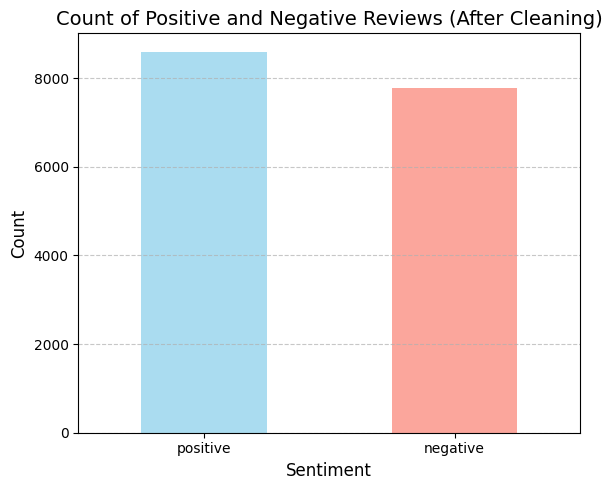

In [ ]:
# Visualizing the 'sentiments'.
# Making sure that the data is not skewed.

senti_counts = data['sentiment'].value_counts()

# Plotting

plt.figure(figsize=(6, 5))
senti_counts.plot(kind='bar', color=['skyblue', 'salmon'], alpha=0.7)
plt.title("Count of Positive and Negative Reviews (After Cleaning)", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#### Building the 'Sentiment-Analysis' pipeline!

In [45]:
# Initializing VADER Sentiment Analyzer.
vader_analyzer = SentimentIntensityAnalyzer()

# Initializing Hugging Face Sentiment Analysis Pipeline.
hugging_face_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [46]:
# Helper functions for applying both classifiers.
# Mapping uncertian cases to 'Neutral' but wont be considering for accuracy for now.

def get_vader_sentiment(text):
    score = vader_analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def get_huggingface_sentiment(text):
    result = hugging_face_pipeline(text)
    if result[0]['label'] == 'POSITIVE':
        return "Positive"
    elif result[0]['label'] == 'NEGATIVE':
        return "Negative"
    else:
        return "Neutral"

In [47]:
# Get the predictions. 

data['vader_pred'] = data['cleaned_text'].apply(get_vader_sentiment)

data['hf_pred'] = data['cleaned_text'].apply(get_huggingface_sentiment)

In [49]:
# Ensuring the data is not serialized.

print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [57]:
# Ensuring the 'sentiment' column is consistent for comparing.

data['sentiment'] = data['sentiment'].str.capitalize()
data.head()

,text,selected_text,sentiment,cleaned_text,vader_pred,hf_pred
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,Negative,sooo sad,Negative,Negative
2,my boss is bullying me...,bullying me,Negative,bullying me,Negative,Negative
3,what interview! leave me alone,leave me alone,Negative,leave me alone,Negative,Negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",Negative,sons of,Neutral,Positive
6,2am feedings for the baby are fun when he is a...,fun,Positive,fun,Positive,Positive


In [60]:
# Dropping the vader neutral predictions. 

final_data = data[data['vader_pred'] != 'Neutral']
final_data.count()

text             13147
selected_text    13147
sentiment        13147
cleaned_text     13147
vader_pred       13147
hf_pred          13147
dtype: int64

#### Evaluating!

In [59]:
# Calculating Accuracy.

vader_acc = accuracy_score(final_data['sentiment'], final_data['vader_pred'])
hf_acc = accuracy_score(final_data['sentiment'], final_data['hf_pred'])

# Printing the accuracy ( % ).

print(f"VADER Accuracy: {vader_acc * 100:.2f}%")
print(f"Hugging Face Accuracy: {hf_acc * 100:.2f}%")

VADER Accuracy: 94.97%
Hugging Face Accuracy: 94.15%
